In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread



In [2]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [3]:
path = "C:/Users/Helene/Documents/03_DataScience/02_FORMATION/OpenClassRooms/01_PROJETS/P6/01_DATA/Flipkart/Images/"


 # import des données

In [12]:
features_texte = np.genfromtxt('../01_DATA/features_USE.csv', delimiter=',')
features_texte.shape


(1050, 512)

In [13]:
features_image_all = np.genfromtxt(
    '../01_DATA/image_features_efficientnet.csv', delimiter=',')
features_image_RedDim = np.genfromtxt(
    '../01_DATA/feat_pca_efficientnet.csv', delimiter=',')

print(features_image_all.shape)
print(features_image_RedDim.shape)


(1050, 1280)
(1050, 683)


In [14]:
features_all = np.concatenate((features_texte, features_image_all), axis=1)
features_all.shape


(1050, 1792)

In [15]:
data = pd.read_csv(
    '../01_DATA/target.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.rename(columns={'categ_0': 'label'})
labels = data["label"]


In [16]:
# transormation des labels en entiers (nécessaire pour calculer matrice de confusion)
labelencoder = LabelEncoder()
labelencoder.fit(labels)
labels_int = labelencoder.transform(labels)
labels_int


array([4, 0, 0, ..., 0, 0, 0])

In [17]:
list_labels = data.label.sort_values().unique()
list_labels


array(['Baby Care ', 'Beauty and Personal Care ', 'Computers ',
       'Home Decor & Festive Needs ', 'Home Furnishing ',
       'Kitchen & Dining ', 'Watches '], dtype=object)

 # Fonctions

In [18]:


def clustering_7classes(X, labels):
    cls = KMeans(n_clusters=7, random_state=0)
    cls.fit(X)

    y_pred = cls.labels_

    ARI = adjusted_rand_score(labels, y_pred)
    print("ARI : {:.3f}".format(ARI))
    return y_pred, ARI


In [19]:


def visu_resultats(features, y_pred, ARI, y_true):
    # Visualisation sur tsne
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 3, 1)
    sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y_true)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Catégorisation de référence")

    plt.subplot(1, 3, 2)
    sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y_pred)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Résultat du clustering automatique\nARI = {:.3f}".format(ARI))

    plt.subplot(1, 3, 3)
    plt.hist(x=y_pred, bins=7)


In [20]:
def erreur_attribution(y_true, y_pred, labels):
    '''
    calcul et affichage de la matrice de confusion pour identifier
    les classes qui sont bien prédites
    '''
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # Alignement le long de la diagonale
    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    labels_df = pd.Series(labels, name="labels").to_frame()
    labels_df['y_true'] = y_true
    labels_df['y_pred'] = y_pred
    labels_df['y_pred_transform'] = labels_df['y_pred'].apply(
        lambda x: corresp[x])
    # re-calcul de la nouvelle matrice de confusion
    conf_mat = confusion_matrix(y_true, labels_df.y_pred_transform)
    print(classification_report(y_true, labels_df.y_pred_transform))
    # visu
    corresp = pd.DataFrame(corresp, columns=['corresp'])
    corresp = corresp.sort_values(by='corresp', axis=0)
    index = list(corresp.index)
    df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                         columns=[i for i in index])
    # columns = [i for i in "0123456"])
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, cmap="Blues")

In [21]:


def reduction_dimension(X):
    print("Réduction de dimension : PCA")
    print("Dimensions dataset avant réduction PCA : ", X.shape)
    pca = PCA(n_components=0.99, random_state=0)
    feat_pca = pca.fit_transform(X)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

    return feat_pca


 # Categorisation
 ## Avec toutes les features disponibles

ARI : 0.493
Correspondance des clusters :  [3 2 4 5 1 6 0]
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       150
           1       0.91      0.79      0.85       150
           2       0.85      0.75      0.80       150
           3       0.48      0.84      0.61       150
           4       0.76      0.46      0.57       150
           5       0.97      0.51      0.67       150
           6       0.97      0.94      0.96       150

    accuracy                           0.72      1050
   macro avg       0.78      0.72      0.73      1050
weighted avg       0.78      0.72      0.73      1050



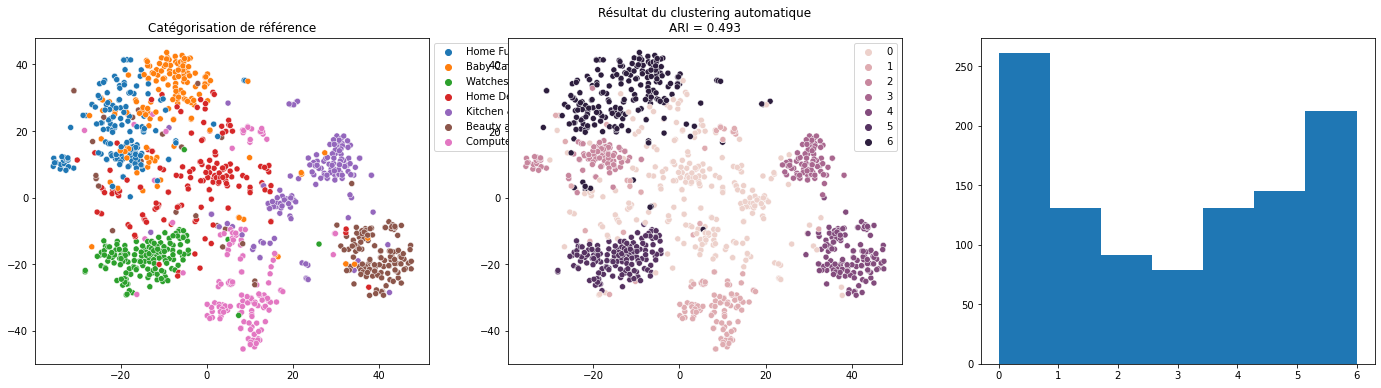

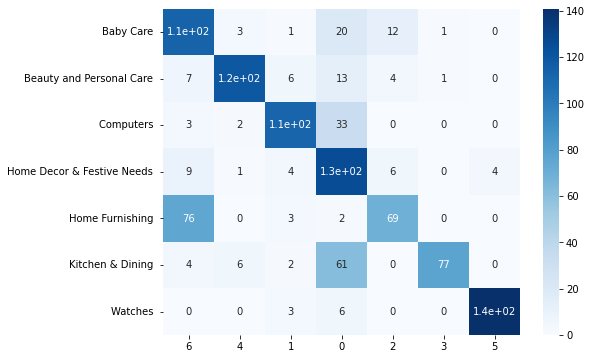

In [22]:
y_pred_all, ARI_all = clustering_7classes(X=features_all, labels=labels)
visu_resultats(features=features_all, y_pred=y_pred_all,
               ARI=ARI_all, y_true=labels)
erreur_attribution(y_true=labels_int, y_pred=y_pred_all, labels=labels)


 ## Avec les features texte + features image avec reduction de dimension

In [23]:
features_RedDim = np.concatenate(
    (features_texte, features_image_RedDim), axis=1)
features_RedDim.shape


(1050, 1195)

ARI : 0.510
Correspondance des clusters :  [2 6 4 1 0 5 3]
              precision    recall  f1-score   support

           0       0.91      0.55      0.68       150
           1       0.92      0.79      0.85       150
           2       0.90      0.75      0.82       150
           3       0.46      0.78      0.57       150
           4       0.62      0.92      0.74       150
           5       0.97      0.51      0.67       150
           6       0.97      0.94      0.95       150

    accuracy                           0.75      1050
   macro avg       0.82      0.75      0.76      1050
weighted avg       0.82      0.75      0.76      1050



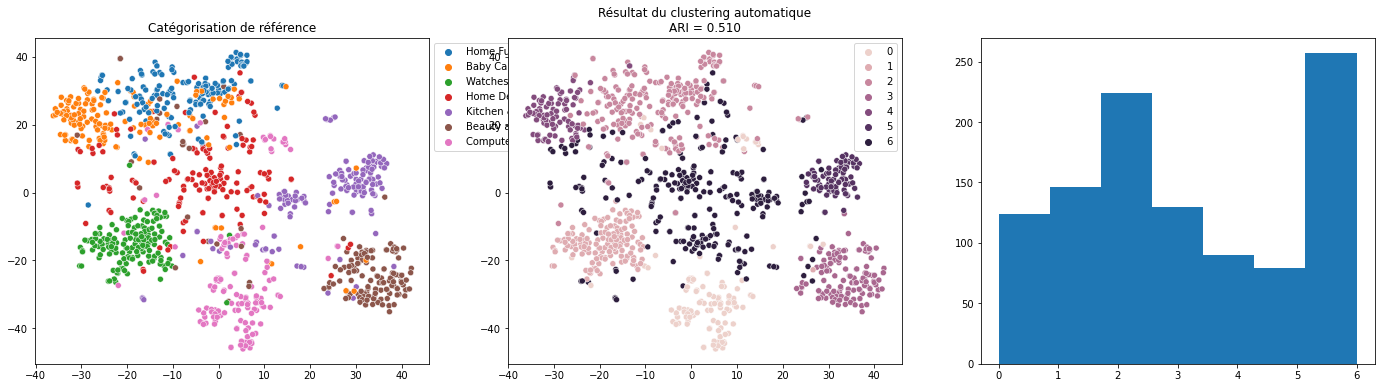

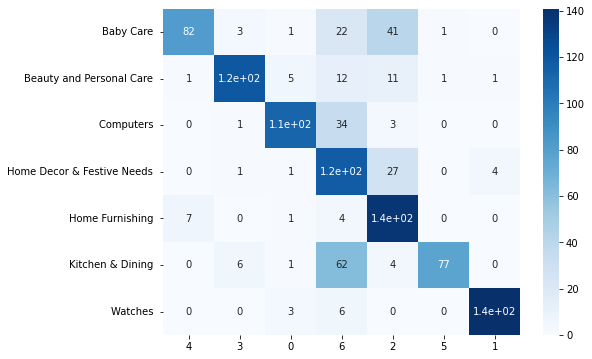

In [24]:
y_pred_RedDim, ARI_RedDim = clustering_7classes(
    X=features_RedDim, labels=labels)
visu_resultats(features=features_RedDim, y_pred=y_pred_RedDim,
               ARI=ARI_RedDim, y_true=labels)
erreur_attribution(y_true=labels_int, y_pred=y_pred_RedDim, labels=labels)


 # Avec toutes les features disponibles suivie d'une réduction de dimension

In [25]:
features_all_RedDim = reduction_dimension(features_all)


Réduction de dimension : PCA
Dimensions dataset avant réduction PCA :  (1050, 1792)
Dimensions dataset après réduction PCA :  (1050, 692)


ARI : 0.510
Correspondance des clusters :  [2 6 4 1 0 5 3]
              precision    recall  f1-score   support

           0       0.91      0.55      0.68       150
           1       0.92      0.79      0.85       150
           2       0.90      0.75      0.82       150
           3       0.46      0.78      0.57       150
           4       0.62      0.92      0.74       150
           5       0.97      0.51      0.67       150
           6       0.97      0.94      0.95       150

    accuracy                           0.75      1050
   macro avg       0.82      0.75      0.76      1050
weighted avg       0.82      0.75      0.76      1050



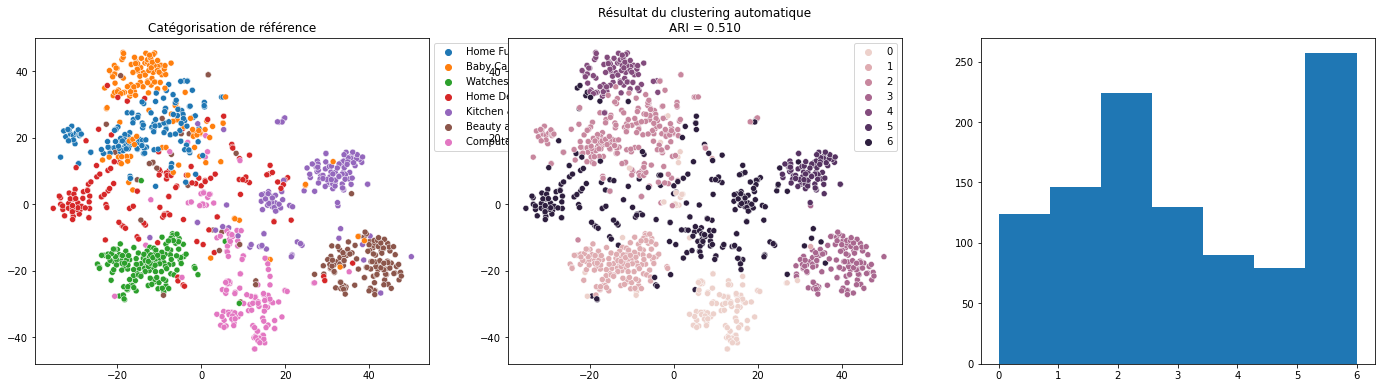

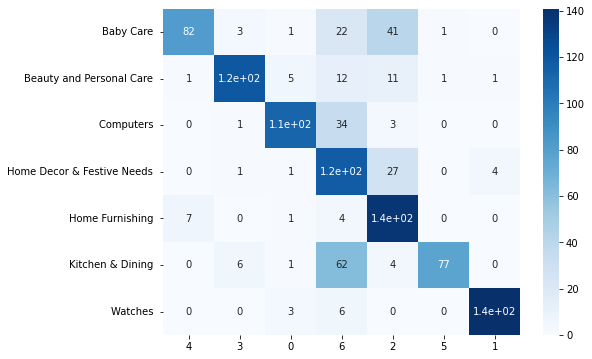

In [26]:
y_pred_all_RedDim, ARI_all_RedDim = clustering_7classes(
    X=features_all_RedDim, labels=labels)
visu_resultats(features=features_all_RedDim,
               y_pred=y_pred_all_RedDim, ARI=ARI_all_RedDim, y_true=labels)
erreur_attribution(y_true=labels_int, y_pred=y_pred_all_RedDim, labels=labels)


 Cluster associé à Home Decor & Festive Needs (cluster 6) contient beaucoup plus d'item que prévu (~250 contre 150 attendus) et une partie de ces items ont une autre attribution par les vendeurs.

In [27]:
labels.unique()


array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [28]:
resultats = data
resultats['Cluster'] = y_pred_all_RedDim


In [29]:
resultats.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   uniq_id  1050 non-null   object
 1   image    1050 non-null   object
 2   label    1050 non-null   object
 3   Cluster  1050 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 28.8+ KB


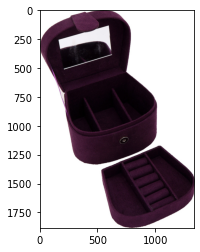

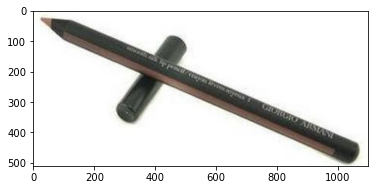

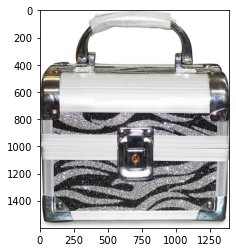

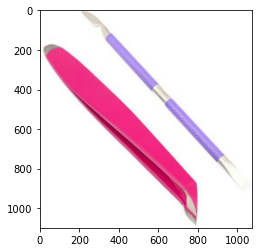

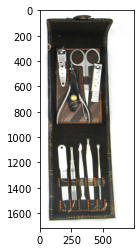

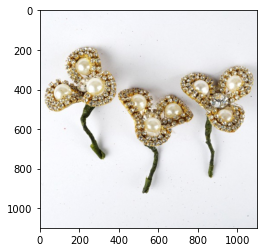

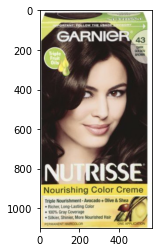

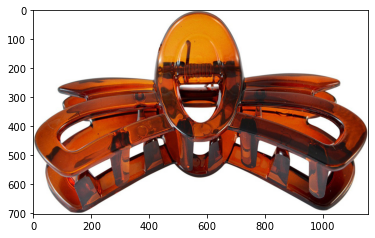

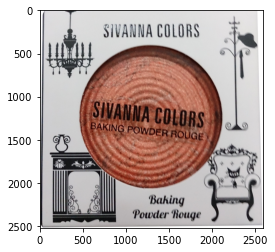

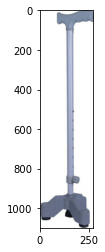

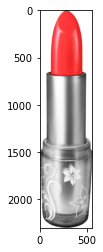

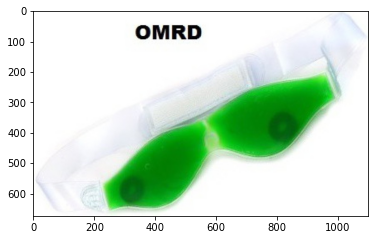

In [30]:
# Cluster 6 (<=> Home decor and festive needs): attributions par vendeurs à 'Beauty and Personal Care'
for i in range(12):
    img = resultats[(resultats.label == 'Beauty and Personal Care ') & (
        resultats.Cluster == 6)].iloc[i, 1]
    filename = path + img
    image = imread(filename)
    plt.imshow(image)
    plt.show()
    print('')


Globalement, associer les features du texte et celles issues des images ne permet pas d'améliorer la classification des produits. Pour autant, la classification obtenue avec uniquement le texte + algo USE ou bien celle obtenue en ré-entrainant l'output d'un CNN de type EfficientNet sur les images permet déjà d'obtenir une classification raisonnable des articles, avec une erreur d'attribution de 16-18%